# Enhanced Real-Time Sentiment Analysis Using Transformer Models and Graph Neural Networks


In [1]:
# from google.colab import files

# uploaded = files.upload()

In [2]:
# !pip install torch_geometric evaluate

In [3]:
# Loading libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
from tqdm.auto import tqdm
from torch.optim import AdamW
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoModel, AutoConfig, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset
from evaluate import load


import warnings
warnings.filterwarnings("ignore")

torch.cuda.empty_cache()

In [4]:
# Loading the twitter airline data
data = pd.read_csv("Tweets.csv")

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
# Checking for null values
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
data.duplicated().sum()

36

In [8]:
# Dropping duplicates
data.drop_duplicates(inplace = True)

In [9]:
data.duplicated().sum()

0

In [10]:
data.shape

(14604, 15)

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14604.0,5.692157e+17,7.782567e+14,5.675883e+17,5.685581e+17,5.694728e+17,5.698885e+17,5.703106e+17
airline_sentiment_confidence,14604.0,8.999228e-01,1.629550e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10503.0,6.376440e-01,3.303799e-01,0.000000e+00,3.605000e-01,6.705000e-01,1.000000e+00,1.000000e+00
retweet_count,14604.0,8.278554e-02,7.466473e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


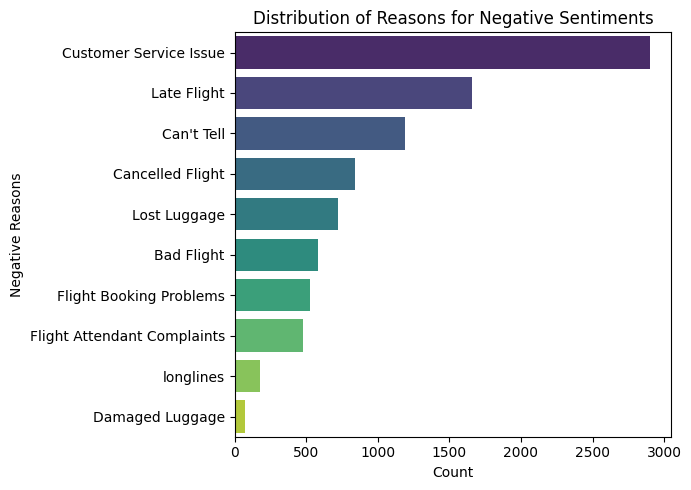

In [12]:
# Filtering the dataframe for negative sentiments only
negative_df = data[data['airline_sentiment'] == 'negative']

# Plotting the chart for distribution of negative reasons
plt.figure(figsize=(7, 5))
sns.countplot(y='negativereason', data=negative_df,
              order=negative_df['negativereason'].value_counts().index,
              palette='viridis')
plt.title('Distribution of Reasons for Negative Sentiments')
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.tight_layout()
plt.show()

The chart above visualizes the distribution of reasons for negative sentiments in airline tweets. It filters the dataset to focus only on tweets with negative sentiments and then plots the frequency of each reported reason for negativity.

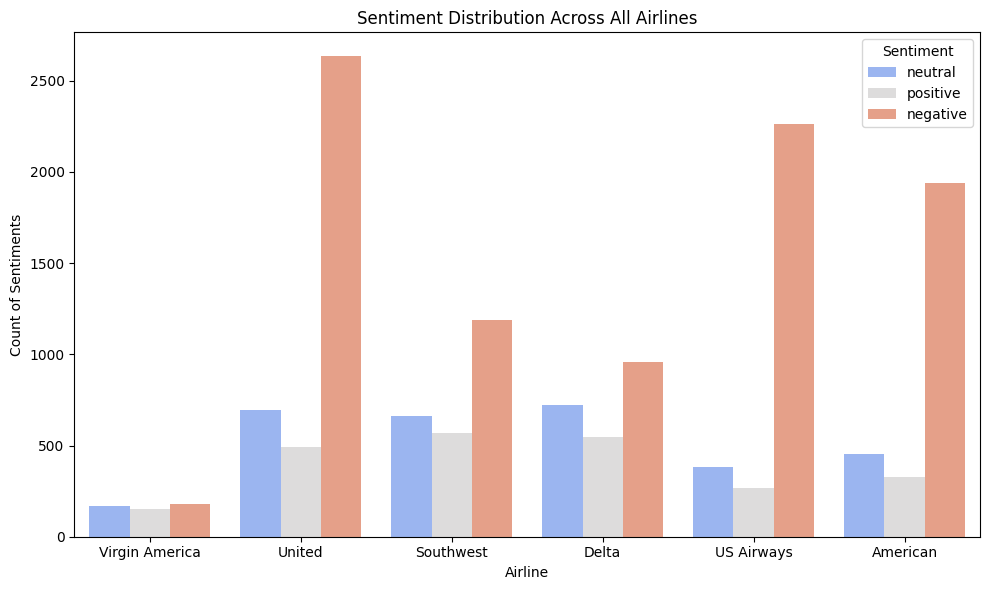

In [13]:
# Plotting the distribution of sentiments for all airlines
plt.figure(figsize=(10, 6))
sns.countplot(x='airline', hue='airline_sentiment', data=data, palette='coolwarm')
plt.title('Sentiment Distribution Across All Airlines')
plt.xlabel('Airline')
plt.ylabel('Count of Sentiments')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

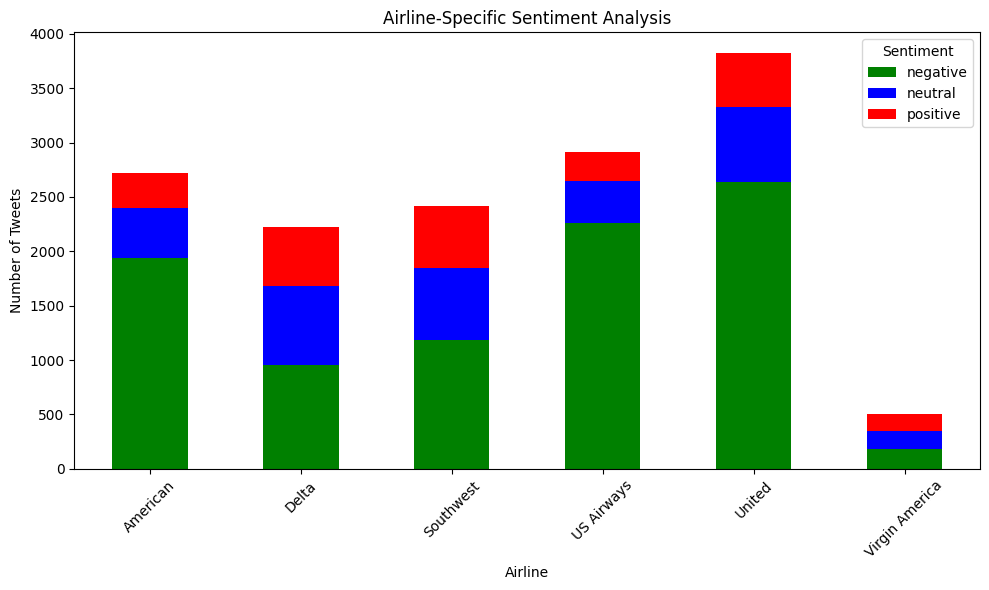

In [14]:
# Grouping data by airline and sentiment
sentiment_count_by_airline = data.groupby(['airline', 'airline_sentiment']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))
sentiment_count_by_airline.plot(kind='bar', stacked=True, color=['green', 'blue', 'red'], figsize=(10, 6))
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.title('Airline-Specific Sentiment Analysis')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


From the Airline specific sentiment chart shows the distribution among airlines, such as United Airlines having more negative sentiment and Virgin America having the least, along with Southwest and United Airlines having more positive sentiment.


In [15]:
# Function to preprocess the text
def preprocess_text(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Single character removal
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Converting to Lowercase
    text = text.lower()

    return text



# Apply the preprocessing to the 'text' column
data['text'] = data['text'].apply(preprocess_text)
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you ve added commercials to the experien...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,didn today must mean need to take another trip,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,it really aggressive to blast obnoxious enter...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [16]:
# Basic preprocessing
data = data[['text', 'airline', 'airline_sentiment']]  # Selecting the relevant columns
data.dropna(inplace=True)  # Dropping the missing values
# Convert categorical labels to numerical
data['airline_sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2], inplace=True)

data

,text,airline,airline_sentiment
0,what said,Virgin America,1
1,plus you ve added commercials to the experien...,Virgin America,2
2,didn today must mean need to take another trip,Virgin America,1
3,it really aggressive to blast obnoxious enter...,Virgin America,0
4,and it a really big bad thing about it,Virgin America,0
...,...,...,...
14635,thank you we got on different flight to chicago,American,2
14636,leaving over minutes late flight no warnings ...,American,0
14637,please bring american airlines to blackberry,American,1
14638,you have my money you change my flight and do...,American,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14604 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14604 non-null  object
 1   airline            14604 non-null  object
 2   airline_sentiment  14604 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 456.4+ KB


In [18]:
# Split the dataset

train_data, test_data = train_test_split(data, test_size=0.4, random_state=42)
train_data = train_data[:2500]
test_data = test_data[:2500]

In [19]:
# Tokenization and Model Loading
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
config = AutoConfig.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", output_hidden_states=True)
bert_model = AutoModel.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment",  config=config)


# Training the GNN Model

In [20]:
# Generate Embeddings for Text Data
def generate_embeddings(texts, model, tokenizer, batch_size=8):
    model.to('cuda')
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    return torch.cat(embeddings, dim=0)

train_embeddings = generate_embeddings(train_data['text'].tolist(), bert_model, tokenizer)
test_embeddings = generate_embeddings(test_data['text'].tolist(), bert_model, tokenizer)

In [21]:
train_embeddings_np = train_embeddings.detach().cpu().numpy()

# Calculate pairwise cosine similarity
similarity_matrix = cosine_similarity(train_embeddings_np)

# Define a threshold for similarity to consider an edge
similarity_threshold = 0.9  # You can adjust this threshold

# Create an edge list
edge_list = []
for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > similarity_threshold:
            edge_list.append((i, j))


In [22]:
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()


In [23]:
train_labels = torch.tensor(train_data['airline_sentiment'].values, dtype=torch.long)
test_labels = torch.tensor(test_data['airline_sentiment'].values, dtype=torch.long)

# Create graph data objects and DataLoader for GNN
train_dataset = [Data(x=train_embeddings, edge_index=edge_index, y=train_labels)]
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = [Data(x=test_embeddings, edge_index=edge_index, y=test_labels)]
test_loader = DataLoader(test_dataset, batch_size=8)



In [24]:

# # Convert edge_index to a NetworkX graph
# G = nx.Graph()
# edge_index_np = edge_index.numpy()
# for i in range(edge_index_np.shape[1]):
#     source, target = edge_index_np[:, i]
#     G.add_edge(int(source), int(target))

# # Draw the graph
# pos = nx.kamada_kawai_layout(G)
# plt.figure(figsize=(15, 15))  # Increase figure size
# nx.draw_networkx_nodes(G, pos, node_size=50)  # Increase node size
# nx.draw_networkx_edges(G, pos, width=0.5)


# plt.title('Text Similarity-Based Graph', fontsize=15)
# plt.show()


In [25]:
# Define the GNN Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        # Initialize GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply the first convolution and activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # Apply the second convolution and activation
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # Apply the third convolution and activation
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.25, training=self.training)

        # Apply the fourth convolution
        x = self.conv4(x, edge_index)

        return torch.log_softmax(x, dim=1)

# Train_embeddings is your input embeddings
input_dim = train_embeddings.shape[1] # Input dimension
hidden_dim = 16 # Hidden dimension
output_dim = 3 # Output dimension (3 classes for sentiment)

gnn_model = GNN(input_dim, hidden_dim, output_dim).to('cuda')


In [26]:
optimizer = AdamW(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

num_epochs = 300
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

losses = []
progress_bar = tqdm(range(num_training_steps))
gnn_model.train()
for epoch in range(num_epochs):

    for batch in train_loader:
        batch.to('cuda')
        outputs = gnn_model(batch)
        loss = criterion(outputs, batch.y)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        progress_bar.update(1)

  0%|          | 0/300 [00:00<?, ?it/s]

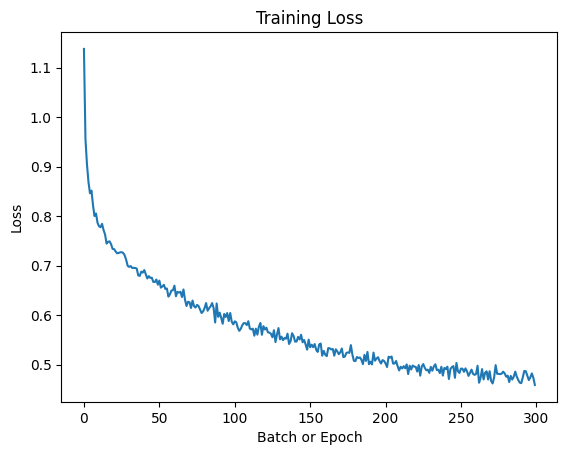

In [27]:
plt.plot(losses)
plt.xlabel('Batch or Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [28]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to('cuda')
            output = model(data)
            _, predicted = torch.max(output, dim=1)

            y_true.extend(data.y.tolist())
            y_pred.extend(predicted.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)


    return accuracy, precision, recall, f1_score


In [29]:
# Move the model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model.to('cuda')

# Evaluate the model
accuracy, precision, recall, f1_score = evaluate_model(gnn_model, test_loader, device)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1_score:.4f}")

Test Accuracy: 0.7372
Test Precision: 0.7309
Test Recall: 0.7372
Test F1-Score: 0.7241


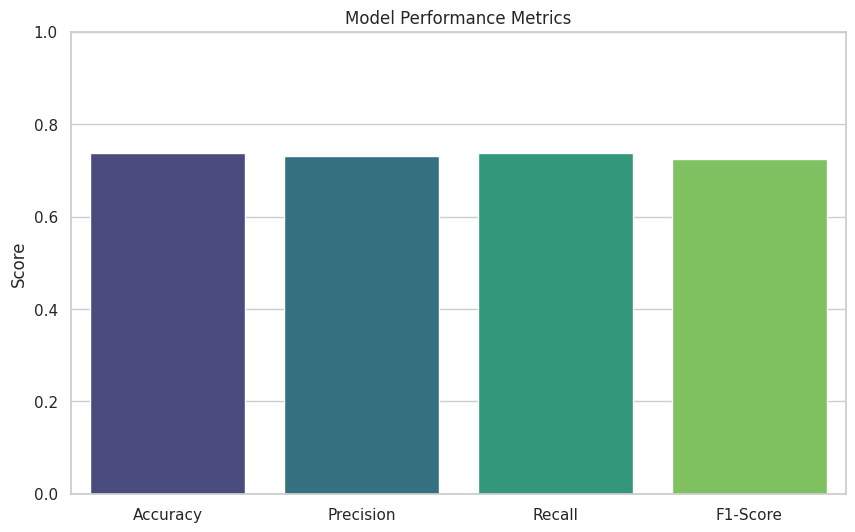

In [30]:
# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

# Display the plot
plt.show()